In [ ]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle
import time

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[]
Num GPUs Available:  0


2023-05-31 03:36:18.321691: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId", 
            "DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId",
           "DMesons_fitOutput__ImpactSignificance"]

print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [5]:
# DMesons_df = generate_df(DMesonsTTree, branches, 2000000)
# DMesons_df = apply_cuts(DMesons_df)

# pd.set_option('display.max_rows', 10)
# DMesons_df

In [220]:
Lambda_df = generate_df(LambdaMesonsTTree, branches, 2000000)
Lambda_df = apply_cuts(Lambda_df)

pd.set_option('display.max_rows', 10)
Lambda_df

In [ ]:
#DMesons_df = remove_duplicates(DMesons_df)
Lambda_df = remove_duplicates(Lambda_df)

Removed 0 duplicate particles


In [11]:
save(DMesons_df, "DMesons_df")
save(Lambda_df, "Lambda_df")

In [221]:
DMesons_df = load("DMesons_df")
Lambda_df = load("Lambda_df")

In [222]:
DMesons_df = DMesons_df.head(500000)
Lambda_df = Lambda_df.head(500000)

In [223]:
#separates each particle of the event into it's own event in a new data frame (for training)
def separate(df):
    dfs = []
    for index, row in df.iterrows():

        #reco Ds
        pts = row['DMesons_pt']
        etas = row['DMesons_eta']
        ms = row['DMesons_m']
        lxys = row['DMesons_fitOutput__Lxy']
        costhetastars = row['DMesons_costhetastar']
        impacts = row['DMesons_fitOutput__ImpactSignificance']
        pdgids = row["DMesons_pdgId"]

        #reco Ds Daughter info
        daughter_pts = row["DMesons_daughterInfo__pt"]
        daughter_etas = row["DMesons_daughterInfo__eta"]
        daughter_phis = row["DMesons_daughterInfo__phi"]
        daughter_pdgIds = row["DMesons_daughterInfo__pdgId"]

        d = {df.columns[0]: pts, df.columns[1]: etas, df.columns[2]: ms, df.columns[3]: lxys, 
             df.columns[4]: costhetastars, df.columns[5]: pdgids, 

             df.columns[6]: daughter_pts, df.columns[7]: daughter_etas, df.columns[8]: daughter_phis, 
             df.columns[9]: daughter_pdgIds, 
             
             df.columns[10]: impacts}
        
        df = pd.DataFrame(data=d)

        dfs.append(df)

    df = pd.concat(dfs)
    df = df.reset_index(drop = True)
    return df

In [ ]:
#DMesons_df = separate(DMesons_df)
Lambda_df = separate(Lambda_df)

In [4]:
# save(DMesons_df, "DMesons_df_separated")
# save(Lambda_df, "Lambda_df_separated")

# DMesons_df = load("DMesons_df_separated")
# Lambda_df = load("Lambda_df_separated")

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [11]:
def count(df):
    D = 0
    Lambda = 0
    for pdgId in df["DMesons_pdgId"]:
        if pdgId == 411 or pdgId == 0:
            D+=1
        elif pdgId == 4122 or pdgId == 1:
            Lambda+=1
    return D, Lambda

count(DMesons_df)

(6280052, 6017574)

In [55]:
def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

DMesons_df['particle_type'] = DMesons_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = DMesons_df[DMesons_df['particle_type'] == 'only_411']
only_4122 = DMesons_df[DMesons_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

#new_df = DMesons_df[DMesons_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [56]:
save(only_4122, "DMesons_only_4122")

In [ ]:
# create a new column 'particle_type' based on the pdgId column

def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

Lambda_df['particle_type'] = Lambda_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = Lambda_df[Lambda_df['particle_type'] == 'only_411']
only_4122 = Lambda_df[Lambda_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

# new_df = Lambda_df[Lambda_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [ ]:
save(only_4122, "Lambda_only_4122")

In [57]:
# Read
Lambda_only_4122 = load("Lambda_only_4122")
DMesons_only_4122 = load("Sherpa_DMesons_only_4122")

In [58]:
len(DMesons_only_4122)

690863

In [59]:
DMesons_only_4122['DMesons_pdgId'] = DMesons_only_4122['DMesons_pdgId'].replace({4122: 411})
Lambda_only_4122 = Lambda_only_4122.reset_index(drop=True)
DMesons_only_4122 = DMesons_only_4122.reset_index(drop=True)
DMesons_only_4122

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance,particle_type
0,124.551781,0.616144,2252.343994,1.000073,0.309355,411,"[45.35352325439453, 55.5874137878418, 23.73572...","(0.62828386, 0.6060324, 0.61673385)","(3.135228, 3.1389863, -3.1324918)","(2212, -321, 211)",1.687575,only_4122
1,52.491680,0.628072,2420.752197,9.001939,-0.999371,411,"[45.325809478759766, 3.1020970344543457, 3.886...","(0.6306876, 0.61715966, 0.6021761)","(3.1351142, 3.1380522, -3.100118)","(2212, -321, 211)",4.709635,only_4122
2,51.824703,0.628606,2289.998535,0.752138,-0.955626,411,"[45.20779800415039, 5.494213104248047, 1.12326...","(0.6285973, 0.60806257, 0.7257996)","(3.135263, 3.1376371, 3.0532124)","(2212, -321, 211)",0.082626,only_4122
3,74.569516,0.623304,2320.748779,0.825154,-0.988731,411,"[45.4151725769043, 5.492096424102783, 23.73572...","(0.6285476, 0.6079869, 0.61673385)","(3.1352143, 3.1375391, -3.1324918)","(2212, -321, 211)",0.285478,only_4122
4,52.139363,0.628442,2114.455566,14.295114,-0.967880,411,"[45.4952392578125, 5.527915000915527, 1.113548...","(0.6305013, 0.60626864, 0.66872984)","(3.1350088, 3.1403995, -3.1118574)","(2212, -321, 211)",4.459208,only_4122
...,...,...,...,...,...,...,...,...,...,...,...,...
690858,15.015752,-1.621316,2128.959717,1.055468,-0.955383,411,"[10.978409767150879, 1.5513936281204224, 2.492...","(-1.6365633, -1.4952528, -1.6247052)","(-0.16868365, -0.11923864, -0.22785482)","(-2212, 321, -211)",4.102871,only_4122
690859,13.776949,-1.625336,2419.603516,0.624960,-0.933207,411,"[11.055854797363281, 1.5394558906555176, 1.245...","(-1.6374356, -1.5005118, -1.6150558)","(-0.1682525, -0.11801015, 0.16930138)","(-2212, 321, -211)",1.601410,only_4122
690860,16.353774,-1.603238,2288.062256,3.461010,-0.961579,411,"[11.229562759399414, 1.516668438911438, 3.6428...","(-1.6382093, -1.4983779, -1.5304362)","(-0.16720171, -0.11406519, -0.21755505)","(-2212, 321, -211)",2.295237,only_4122
690861,14.328731,-1.612592,2169.589355,1.799214,-0.948991,411,"[11.196073532104492, 1.5245026350021362, 1.622...","(-1.6378483, -1.4999491, -1.5262128)","(-0.16747509, -0.1153605, -0.27906275)","(-2212, 321, -211)",2.297870,only_4122


In [61]:
Lambda_only_4122 = Lambda_only_4122.head(500000)
DMesons_only_4122 = DMesons_only_4122.head(500000)

#combined_df = pd.concat([Lambda_only_4122, DMesons_only_4122], axis=0)

# Shuffle the rows of the combined data frame
#shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

Text(0.5, 0, 'Mass (MeV)')

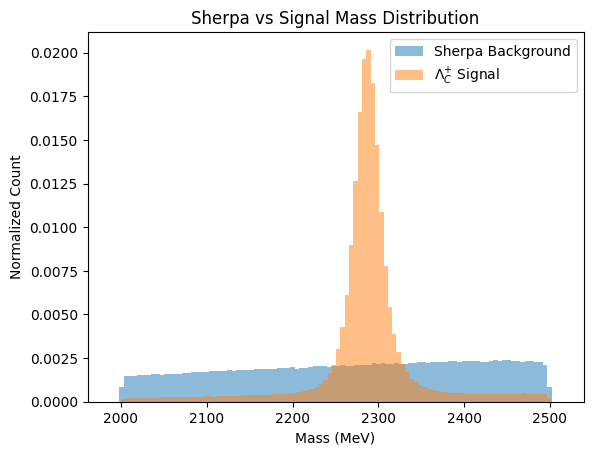

In [62]:
counts, bins, _ = plt.hist(DMesons_only_4122["DMesons_m"], bins=100)
counts2, bins2, _ = plt.hist(Lambda_only_4122["DMesons_m"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

    # Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs Signal Mass Distribution")
plt.legend()
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")

In [14]:
#shuffled_df['DMesons_daughterInfo__pdgId'] = [(2212, -321, 211)] * len(shuffled_df)

In [63]:
DMesons_only_4122['DMesons_daughterInfo__pdgId'] = [(2212, -321, 211)] * len(DMesons_only_4122)

/tmp/ipykernel_42831/3865868314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DMesons_only_4122['DMesons_daughterInfo__pdgId'] = [(2212, -321, 211)] * len(DMesons_only_4122)


In [65]:
# shuffled_df["DMesons_daughterInfo__eta"] = shuffled_df["DMesons_daughterInfo__eta"].apply(list)
# shuffled_df["DMesons_daughterInfo__phi"] = shuffled_df["DMesons_daughterInfo__phi"].apply(list)

In [66]:
DMesons_only_4122["DMesons_daughterInfo__eta"] = DMesons_only_4122["DMesons_daughterInfo__eta"].apply(list)
DMesons_only_4122["DMesons_daughterInfo__phi"] = DMesons_only_4122["DMesons_daughterInfo__phi"].apply(list)

Lambda_only_4122["DMesons_daughterInfo__eta"] = Lambda_only_4122["DMesons_daughterInfo__eta"].apply(list)
Lambda_only_4122["DMesons_daughterInfo__phi"] = Lambda_only_4122["DMesons_daughterInfo__phi"].apply(list)

/tmp/ipykernel_42831/3911453514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DMesons_only_4122["DMesons_daughterInfo__eta"] = DMesons_only_4122["DMesons_daughterInfo__eta"].apply(list)
/tmp/ipykernel_42831/3911453514.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DMesons_only_4122["DMesons_daughterInfo__phi"] = DMesons_only_4122["DMesons_daughterInfo__phi"].apply(list)
/tmp/ipykernel_42831/3911453514.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [ ]:
#shuffled_df_daughter = shuffled_df[["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"]]

In [16]:
#separate the daughter info
daughter_pts = []
daughter_etas = []
daughter_phis = []

for index, row in shuffled_df.iterrows():

    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    
    for pt, eta, phi in zip(pts, etas, phis):
        daughter_pts.append(pt)
        daughter_etas.append(eta)
        daughter_phis.append(phi)

In [17]:
#particle1 is proton, or pion in D+ hyp
#particle2 is kaon
#particle3 is pion

particle1_pt = []
particle2_pt = []
particle3_pt = []

particle1_eta = []
particle2_eta = []
particle3_eta = []

particle1_phi = []
particle2_phi = []
particle3_phi = []

for i in range(0, len(daughter_pts), 3):
    #daughter_pt
    particle1_pt.append(daughter_pts[i])
    particle2_pt.append(daughter_pts[i+1])
    particle3_pt.append(daughter_pts[i+2])
    
    #daughter_eta
    particle1_eta.append(daughter_etas[i])
    particle2_eta.append(daughter_etas[i+1])
    particle3_eta.append(daughter_etas[i+2])
    
    #daughter_phi
    particle1_phi.append(daughter_phis[i])
    particle2_phi.append(daughter_phis[i+1])
    particle3_phi.append(daughter_phis[i+2])

In [ ]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
#inv_mass3 pipi (assuming p is pi)

#pions
#inv_mass4 is pion pion (first pion was proton) (second pion was kaon)
#inv_mass5 is pion pion (first pion was kaon) (second is still pion)
#inv_mass6 is pion pion (first pion was proton) (second is still pion)

#Lambda Hypothesis
#inv_mass7 is pk assuming proton is proton
#inv_mass8 is kpi
#inv_mass9 ppi

In [176]:
k_mass = 0.493677 #Gev/c^2
pi_mass = 0.13957 #Gev/c^2
p_mass = 0.938 #Gev/c^2

def createTLorentzVectors(df):
    TLorentzVectorList = []
    
    for index, row in df.iterrows():
        pts = row['DMesons_daughterInfo__pt']
        etas = row['DMesons_daughterInfo__eta']
        phis = row['DMesons_daughterInfo__phi']
        pdgids = row['DMesons_daughterInfo__pdgId']
        types = row["particle_type"]
        
        def assign_mass():
            if types == "only_411" or "only_4122":
                #D+ Hypothesis: assume proton is pion for 
                #Lambda Hypothesis: keep proton as proton
                return pi_mass
            else:
                raise Exception("Are there more particle types?")
            
        for pt, eta, phi, pdgid in zip(pts, etas, phis, pdgids):
            if pdgid == 211:
                m = pi_mass
            elif pdgid == -321:
                m = k_mass
            elif pdgid == 2212:
                m = assign_mass()
            else:
                continue

            p = ROOT.TLorentzVector()
            p.SetPtEtaPhiM(pt, eta, phi, m)
            TLorentzVectorList.append(p)

    return TLorentzVectorList

inv_mass_squared = lambda p1, p2: (p1 + p2).M2()

In [20]:
LorentzVectors = createTLorentzVectors(shuffled_df)
reshaped_list = [LorentzVectors[i:i+3] for i in range(0, len(LorentzVectors), 3)]
np.shape(reshaped_list)

In [177]:
LorentzVectors1 = createTLorentzVectors(Lambda_only_4122)
reshaped_list1 = [LorentzVectors1[i:i+3] for i in range(0, len(LorentzVectors1), 3)]
np.shape(reshaped_list1)

(500000, 3)

In [178]:
LorentzVectors2 = createTLorentzVectors(DMesons_only_4122)
reshaped_list2 = [LorentzVectors2[i:i+3] for i in range(0, len(LorentzVectors2), 3)]
np.shape(reshaped_list2)

(500000, 3)

In [191]:
pk_list = []
kpi_list = []
ppi_list = []

#find the ordering of the Lorentz Vectors

#Lambda Hypothesis
# p_LorentzVectors = []
# k_LorentzVectors = []
# pi_LorentzVectors = []
# for i in LorentzVectors1:
#     if round(i.M(), 3) == p_mass:
#         p_LorentzVectors.append(i)
#     elif round(i.M(), 6) == k_mass:
#         k_LorentzVectors.append(i)
#     elif round(i.M(), 4) == 0.1396:
#         pi_LorentzVectors.append(i)

#D+ Hypothesis
# p_LorentzVectors = []
# k_LorentzVectors = []
# pi_LorentzVectors = []
# for sublist in reshaped_list2:
#     for i in range(len(sublist)):
#         if round(sublist[i].M(), 4) == 0.1396 and i == 0:
#             p_LorentzVectors.append(sublist[0])
#         elif round(sublist[i].M(), 4) == 0.4937 and i == 1:
#             k_LorentzVectors.append(sublist[1])
#         elif round(sublist[i].M(), 4) == 0.1396 and i == 2:
#             pi_LorentzVectors.append(sublist[2])

#Pions
p_LorentzVectors = []
k_LorentzVectors = []
pi_LorentzVectors = []
for sublist in reshaped_list2:
    for i in range(len(sublist)):
        if round(sublist[i].M(), 4) == 0.1396 and i == 0:
            p_LorentzVectors.append(sublist[0])
        elif round(sublist[i].M(), 4) == 0.1396 and i == 1:
            k_LorentzVectors.append(sublist[1])
        elif round(sublist[i].M(), 4) == 0.1396 and i == 2:
            pi_LorentzVectors.append(sublist[2])

In [194]:
for i in range(len(p_LorentzVectors)):
    pk = inv_mass_squared(p_LorentzVectors[i], k_LorentzVectors[i])
    kpi = inv_mass_squared(k_LorentzVectors[i], pi_LorentzVectors[i])
    ppi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
    pk_list.append(pk)
    kpi_list.append(kpi)
    ppi_list.append(ppi)

In [136]:
kpi_low = []
kpi_high = []

for sublist in reshaped_list2:
    kpi_one = inv_mass_squared(sublist[0], sublist[1])
    kpi_two = inv_mass_squared(sublist[1], sublist[2])
    if kpi_one > kpi_two:
        kpi_high.append(kpi_one)
        kpi_low.append(kpi_two)
    else:
        #kpi_one < kpi_kpi_two:
        kpi_high.append(kpi_two)
        kpi_low.append(kpi_one)

Text(0.5, 1.0, 'Scatter Plot $pk^{-} -> \\pi^{+}k^{-}$ and $k^{-}\\pi^{+}$')

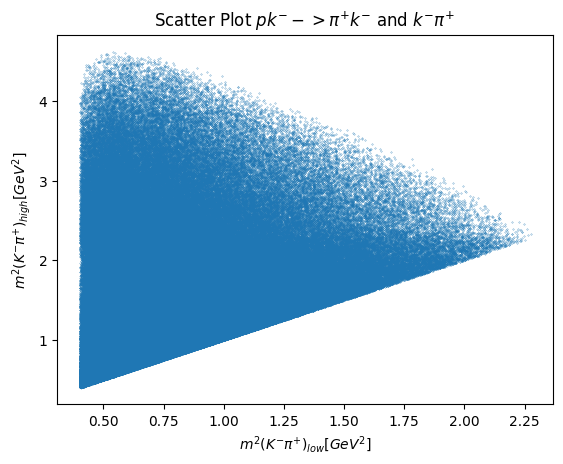

In [154]:
plt.scatter(kpi_low, kpi_high, s = 0.05)
plt.xlabel("$m^{2}(K^{-}\pi^{+})_{low} [GeV^{2}]$")
plt.ylabel("$m^{2}(K^{-}\pi^{+})_{high} [GeV^{2}]$")
plt.title("Scatter Plot $pk^{-} -> \pi^{+}k^{-}$ and $k^{-}\pi^{+}$")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


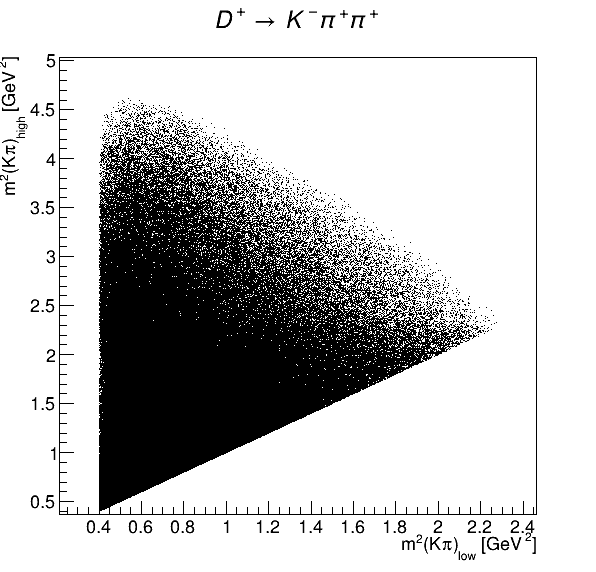

In [122]:
# Create a TGraph from the x and y arrays
graph = createTGraph(np.array(kpi_low), np.array(kpi_high), title=r"$D^{+} \rightarrow K^{-}\pi^{+}\pi^{+}$", xtitle="m^{2}(K#pi)_{low} [GeV^{2}]", ytitle="m^{2}(K#pi)_{high} [GeV^{2}]")

# Draw the TGraph
c = ROOT.TCanvas("c", "c", 600, 600)
graph.SetMarkerColor(1) # Black
graph.SetMarkerStyle(1)
graph.Draw("AP")
c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


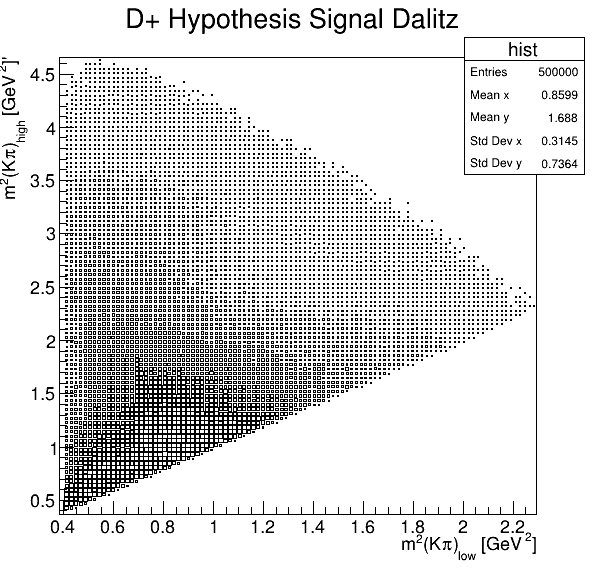

In [123]:
nbinsx = 100
xmin = np.min(kpi_low)
xmax = np.max(kpi_low)

nbinsy = 100
ymin = np.min(kpi_high)
ymax = np.max(kpi_high)

hist = create_2dhistogram(kpi_low, kpi_high, r"D+ Hypothesis Signal Dalitz", "m^{2}(K#pi)_{low} [GeV^{2}]", "m^{2}(K#pi)_{high} [GeV^{2}]'", 100, np.min(kpi_low), np.max(kpi_low), 100, np.min(kpi_high), np.max(kpi_high))
canvas = ROOT.TCanvas("canvas", "Canvas Title", 600, 600)

hist.SetOption("BOX")
hist.SetLineColor(ROOT.kBlack)
hist.GetYaxis().SetRangeUser(0, 20)
hist.GetXaxis().SetRangeUser(0, 20)
hist.Draw()
canvas.Draw()

Text(0.5, 1.0, 'Scatter Plot $pk^{-}$ vs $k^{-}\\pi^{+}$')

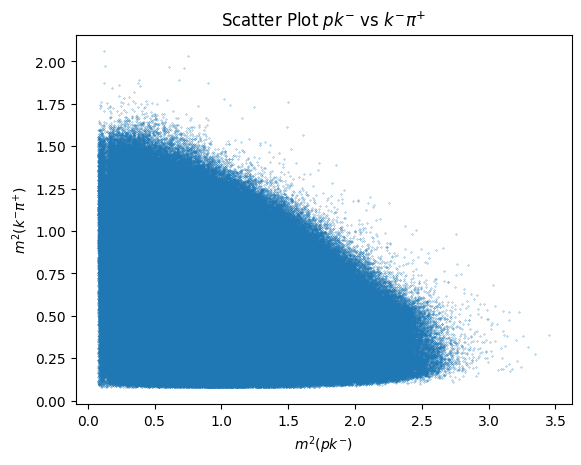

In [181]:
plt.scatter(pk_list, kpi_list, s = 0.05)
plt.xlabel("$m^2(pk^{-})$")
plt.ylabel("$m^2(k^{-}\pi^{+})$")
#plt.title("Scatter Plot $pk^{-} -> \pi^{+}k^{-}$ and $k^{-}\pi^{+}$")
plt.title("Scatter Plot $pk^{-}$ vs $k^{-}\pi^{+}$")

Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


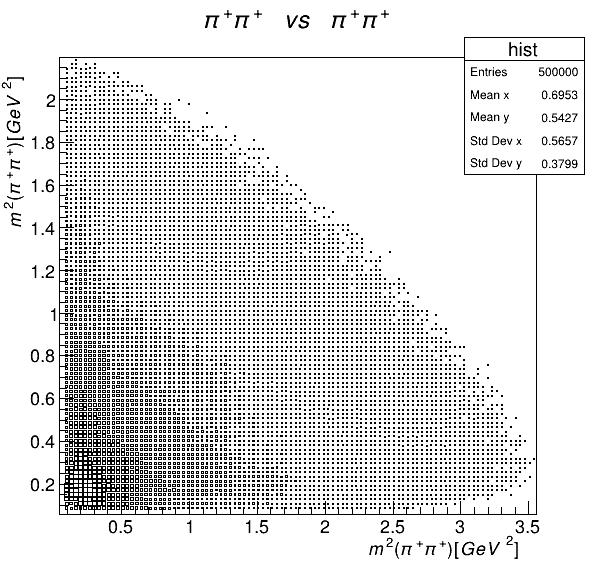

In [195]:
nbinsx = 100
xmin = np.min(pk_list)
xmax = np.max(pk_list)

nbinsy = 100
ymin = np.min(kpi_list)
ymax = np.max(kpi_list)

hist = create_2dhistogram(pk_list, kpi_list, r"$\pi^{+}\pi^{+}$ vs $\pi^{+}\pi^{+}$", "$m^{2}(\pi^{+}\pi^{+}) [GeV^{2}]$", "m^{2}(\pi^{+}\pi^{+}) [GeV^{2}]'", 100, np.min(pk_list), np.max(pk_list), 100, np.min(kpi_list), np.max(kpi_list))
canvas = ROOT.TCanvas("canvas", "Canvas Title", 600, 600)

hist.SetOption("BOX")
hist.SetLineColor(ROOT.kBlack)
hist.GetYaxis().SetRangeUser(0, 20)
hist.GetXaxis().SetRangeUser(0, 20)
hist.Draw()
canvas.Draw()

Text(0.5, 1.0, 'Scatter Plot $\\pi^{+}k^{-}$ vs $\\pi^{+}\\pi^{+}$')

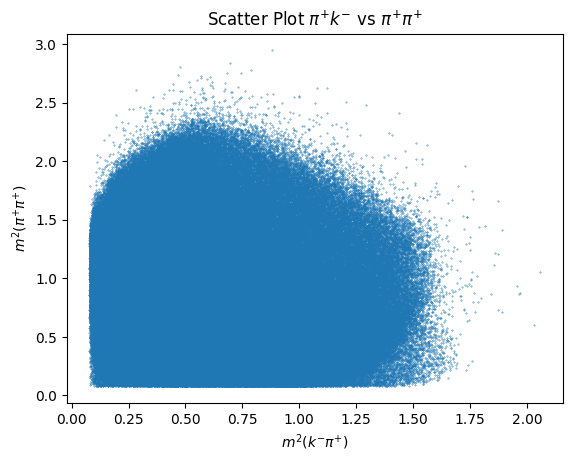

In [186]:
plt.scatter(kpi_list, ppi_list, s = 0.1)
plt.xlabel("$m^2(k^{-}\pi^{+})$")
plt.ylabel("$m^2(\pi^{+}\pi^{+})$")
#plt.title("Scatter Plot $pk^{-} -> \pi^{+}k^{-}$ vs $\pi^{+}\pi^{+}$")
plt.title("Scatter Plot $\pi^{+}k^{-}$ vs $\pi^{+}\pi^{+}$")

Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


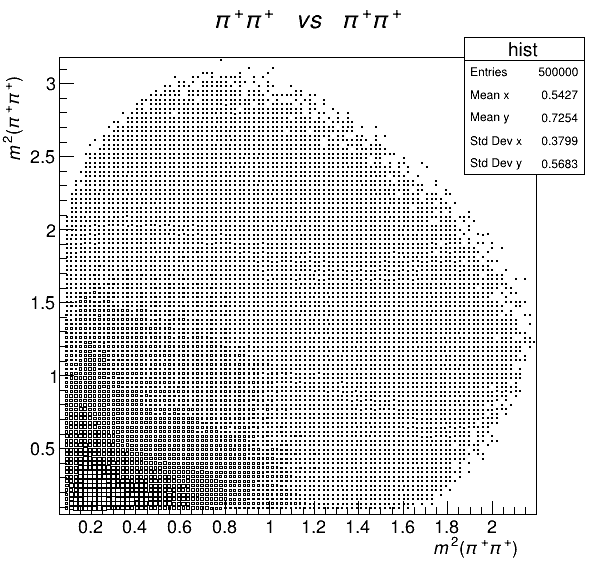

In [196]:
nbinsx = 100
xmin = np.min(kpi_list)
xmax = np.max(kpi_list)

nbinsy = 100
ymin = np.min(ppi_list)
ymax = np.max(ppi_list)

hist = create_2dhistogram(kpi_list, ppi_list, r"$\pi^{+}\pi^{+}$ vs $\pi^{+}\pi^{+}", "$m^2(\pi^{+}\pi^{+})$", "$m^2(\pi^{+}\pi^{+})$", 100, np.min(kpi_list), np.max(kpi_list), 100, np.min(ppi_list), np.max(ppi_list))
canvas = ROOT.TCanvas("canvas", "Canvas Title", 600, 600)

hist.SetOption("BOX")
hist.SetLineColor(ROOT.kBlack)
hist.GetYaxis().SetRangeUser(0, 20)
hist.GetXaxis().SetRangeUser(0, 20)
hist.Draw()
canvas.Draw()

Text(0.5, 1.0, 'Scatter Plot $pk^{-}$ vs $p\\pi^{+}$')

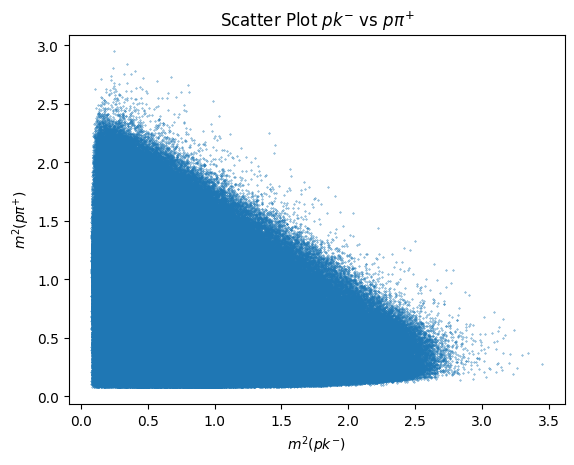

In [189]:
plt.scatter(pk_list, ppi_list, s = 0.1)
plt.xlabel("$m^2(pk^{-})$")
plt.ylabel("$m^2(p\pi^{+})$")
#plt.title("Scatter Plot $pk^{-} -> pk^{-}$ vs $p\pi^{+}$")
plt.title("Scatter Plot $pk^{-}$ vs $p\pi^{+}$")

Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


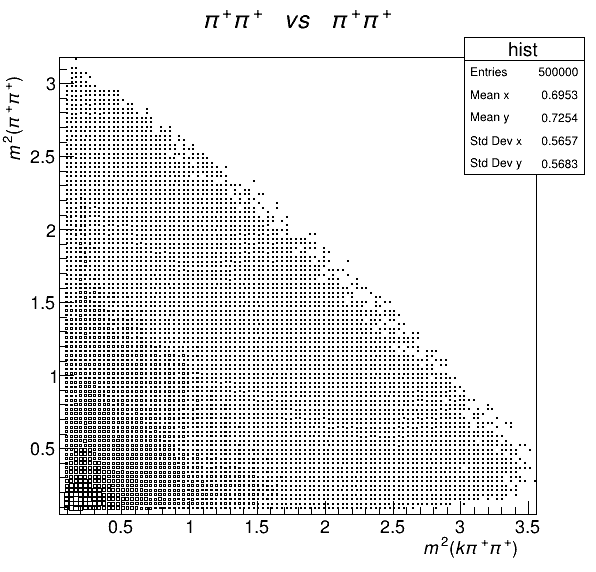

In [198]:
nbinsx = 100
xmin = np.min(pk_list)
xmax = np.max(pk_list)

nbinsy = 100
ymin = np.min(ppi_list)
ymax = np.max(ppi_list)

hist = create_2dhistogram(pk_list, ppi_list, r"\pi^{+}\pi^{+}$ vs $\pi^{+}\pi^{+}", "$m^2(k\pi^{+}\pi^{+})$", "$m^2(\pi^{+}\pi^{+})$", 100, np.min(pk_list), np.max(pk_list), 100, np.min(ppi_list), np.max(ppi_list))
canvas = ROOT.TCanvas("canvas", "Canvas Title", 600, 600)

hist.SetOption("BOX")
hist.SetLineColor(ROOT.kBlack)
hist.GetYaxis().SetRangeUser(0, 20)
hist.GetXaxis().SetRangeUser(0, 20)
hist.Draw()
canvas.Draw()

In [197]:
#Lambda
# for i in range(len(p_LorentzVectors)):
#     ppi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
#     ppi_list.append(ppi)

In [190]:
#D
# for i in range(len(p_LorentzVectors)):
#     pipi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
#     pipi_list.append(pipi)

In [264]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
#inv_mass3 pipi (assuming p is pi)

#pions
#inv_mass4 is pion pion (first pion was proton) (second pion was kaon)
#inv_mass5 is pion pion (first pion was kaon) (second is still pion)
#inv_mass6 is pion pion (first pion was proton) (second is still pion)

#Lambda Hypothesis
#inv_mass7 is pk assuming proton is proton
#inv_mass8 is kpi
#inv_mass9 ppi

shuffled_df['inv_mass7'] = pk_list
shuffled_df['inv_mass8'] = kpi_list
shuffled_df['inv_mass9'] = ppi_list

In [265]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,...,particle_type,inv_mass1,inv_mass2,inv_mass3,inv_mass4,inv_mass5,inv_mass6,inv_mass7,inv_mass8,inv_mass9
0,14.551307,-0.503012,2211.277832,0.105686,-0.462903,411,"[11.170928001403809, 2.831317901611328, 0.6029...","[-0.4977727, -0.55253094, -0.31940895]","[0.45178226, 0.5159005, 0.88359225]","(2212, -321, 211)",...,only_4122,1.424463,0.732076,1.873404,0.343701,0.463657,1.873404,2.510926,0.732076,2.778089
1,10.616373,-1.239521,2226.512207,0.547223,0.957469,411,"[3.040483236312866, 6.920453071594238, 0.66697...","[-1.2389119, -1.2671988, -0.891992]","[2.288972, 2.2705233, 2.100124]","(2212, -321, 211)",...,only_4122,0.437135,1.342377,0.476848,0.116725,1.101903,0.476848,3.291010,1.342377,1.481510
2,8.041471,0.740541,2292.695068,0.648762,-0.224572,4122,"[4.130668640136719, 2.183924913406372, 1.80589...","[0.61786264, 0.9393891, 0.7249763]","[-2.7951388, -3.0525513, -2.6634498]","(2212, -321, 211)",...,only_4122,2.183149,1.235540,0.304696,1.616657,0.851758,0.304696,3.605317,1.235540,1.562662
3,14.505914,1.700047,2277.017822,0.415693,0.281155,4122,"[5.195446968078613, 7.804042816162109, 1.53329...","[1.7886169, 1.6211084, 1.7547115]","[-0.67071944, -0.5331284, -0.63166416]","(2212, -321, 211)",...,only_4122,2.384678,0.734953,0.133974,1.985845,0.460789,0.133974,4.349245,0.734953,1.240154
4,9.190323,0.948899,2467.892822,0.088807,-0.964863,411,"[5.592108726501465, 0.7378090620040894, 2.8988...","[1.0165381, 0.6699291, 0.87115043]","[0.7204874, 0.5911911, 0.61206007]","(2212, -321, 211)",...,only_4122,3.025494,1.376170,0.623499,0.796600,0.217839,0.623499,3.987457,1.376170,1.883637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,32.272094,-0.041371,2258.133057,0.269147,-0.166023,4122,"[19.53499984741211, 10.94820785522461, 1.82099...","[-0.059171885, -0.013583427, -0.018911816]","[-2.877898, -2.9645057, -2.8272035]","(2212, -321, 211)",...,only_4122,2.757283,0.796590,0.398840,2.132483,0.534964,0.398840,4.099238,0.796590,1.339467
999996,49.044613,-1.551618,2302.039551,0.211826,0.901419,411,"[10.073150634765625, 30.05179214477539, 8.9344...","[-1.5475895, -1.54694, -1.5712011]","[1.316317, 1.3007066, 1.3279157]","(2212, -321, 211)",...,only_4122,0.476911,0.758174,0.140392,0.177466,0.465773,0.140392,3.901641,0.758174,1.780263
999997,15.512543,-0.002953,2162.263672,0.298673,-0.881231,411,"[12.885456085205078, 2.0564074516296387, 0.600...","[0.013616143, -0.08536845, -0.07438314]","[0.5507237, 0.59127384, 0.8937046]","(2212, -321, 211)",...,only_4122,2.070365,0.513330,1.412748,0.466976,0.222930,1.412748,3.072219,0.513330,2.314334
999998,9.649199,0.248185,2028.827759,0.154665,0.676143,411,"[3.514936923980713, 5.062290668487549, 1.09335...","[0.21267407, 0.22728372, 0.44851756]","[-1.1488833, -1.3185775, -1.2333149]","(2212, -321, 211)",...,only_4122,0.974722,0.715890,0.345574,0.595541,0.439397,0.345574,3.062715,0.715890,1.491429


In [266]:
invmass_ready_df = shuffled_df.drop(['DMesons_daughterInfo__pt', 'DMesons_daughterInfo__eta', "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"], axis=1)
invmass_ready_df["daughter_pt1"] = particle1_pt
invmass_ready_df["daughter_pt2"] = particle2_pt
invmass_ready_df["daughter_pt3"] = particle3_pt
invmass_ready_df["daughter_eta1"] = particle1_eta
invmass_ready_df["daughter_eta2"] = particle2_eta
invmass_ready_df["daughter_eta3"] = particle3_eta
invmass_ready_df["daughter_phi1"] = particle1_phi
invmass_ready_df["daughter_phi2"] = particle2_phi
invmass_ready_df["daughter_phi3"] = particle3_phi
invmass_ready_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,14.551307,-0.503012,2211.277832,0.105686,-0.462903,411,1.598548,1.424463,0.732076,1.873404,...,2.778089,11.170928,2.831318,0.602950,-0.497773,-0.552531,-0.319409,0.451782,0.515900,0.883592
1,10.616373,-1.239521,2226.512207,0.547223,0.957469,411,2.001802,0.437135,1.342377,0.476848,...,1.481510,3.040483,6.920453,0.666974,-1.238912,-1.267199,-0.891992,2.288972,2.270523,2.100124
2,8.041471,0.740541,2292.695068,0.648762,-0.224572,4122,0.782303,2.183149,1.235540,0.304696,...,1.562662,4.130669,2.183925,1.805893,0.617863,0.939389,0.724976,-2.795139,-3.052551,-2.663450
3,14.505914,1.700047,2277.017822,0.415693,0.281155,4122,1.275064,2.384678,0.734953,0.133974,...,1.240154,5.195447,7.804043,1.533298,1.788617,1.621108,1.754712,-0.670719,-0.533128,-0.631664
4,9.190323,0.948899,2467.892822,0.088807,-0.964863,411,2.443815,3.025494,1.376170,0.623499,...,1.883637,5.592109,0.737809,2.898830,1.016538,0.669929,0.871150,0.720487,0.591191,0.612060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,32.272094,-0.041371,2258.133057,0.269147,-0.166023,4122,2.293643,2.757283,0.796590,0.398840,...,1.339467,19.535000,10.948208,1.820998,-0.059172,-0.013583,-0.018912,-2.877898,-2.964506,-2.827204
999996,49.044613,-1.551618,2302.039551,0.211826,0.901419,411,0.641638,0.476911,0.758174,0.140392,...,1.780263,10.073151,30.051792,8.934455,-1.547590,-1.546940,-1.571201,1.316317,1.300707,1.327916
999997,15.512543,-0.002953,2162.263672,0.298673,-0.881231,411,0.989076,2.070365,0.513330,1.412748,...,2.314334,12.885456,2.056407,0.600632,0.013616,-0.085368,-0.074383,0.550724,0.591274,0.893705
999998,9.649199,0.248185,2028.827759,0.154665,0.676143,411,0.318123,0.974722,0.715890,0.345574,...,1.491429,3.514937,5.062291,1.093358,0.212674,0.227284,0.448518,-1.148883,-1.318578,-1.233315


In [54]:
#save(invmass_ready_df, "Sherpa_invmass_ready_df")
invmass_ready_df = load("Sherpa_invmass_ready_df")

In [55]:
# create a new column 'particle_type' based on the pdgId column
def func(x):
    if x == 0 or x == 411:
        return 'only_411'
    elif x == 1 or x == 4122:
        return 'only_4122'

invmass_ready_df['particle_type'] = invmass_ready_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_411']
only_4122 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_4122']

new_df = invmass_ready_df[invmass_ready_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)
# only_411 = only_411.reset_index(drop=True)
# only_4122 = only_4122.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [56]:
only_411 = only_411.drop('particle_type', axis=1)
only_4122 = only_4122.drop('particle_type', axis=1)
new_df = new_df.drop("particle_type", axis=1)

# new_df = new_df.drop('DMesons_m', axis=1)
# only_411 = only_411.drop('DMesons_m', axis=1)
# only_4122 = only_4122.drop('DMesons_m', axis=1)

In [57]:
new_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,14.551307,-0.503012,2211.277832,0.105686,-0.462903,411,1.598548,1.424463,0.732076,1.873404,...,2.778089,11.170928,2.831318,0.602950,-0.497773,-0.552531,-0.319409,0.451782,0.515900,0.883592
1,10.616373,-1.239521,2226.512207,0.547223,0.957469,411,2.001802,0.437135,1.342377,0.476848,...,1.481510,3.040483,6.920453,0.666974,-1.238912,-1.267199,-0.891992,2.288972,2.270523,2.100124
2,8.041471,0.740541,2292.695068,0.648762,-0.224572,4122,0.782303,2.183149,1.235540,0.304696,...,1.562662,4.130669,2.183925,1.805893,0.617863,0.939389,0.724976,-2.795139,-3.052551,-2.663450
3,14.505914,1.700047,2277.017822,0.415693,0.281155,4122,1.275064,2.384678,0.734953,0.133974,...,1.240154,5.195447,7.804043,1.533298,1.788617,1.621108,1.754712,-0.670719,-0.533128,-0.631664
4,9.190323,0.948899,2467.892822,0.088807,-0.964863,411,2.443815,3.025494,1.376170,0.623499,...,1.883637,5.592109,0.737809,2.898830,1.016538,0.669929,0.871150,0.720487,0.591191,0.612060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,32.272094,-0.041371,2258.133057,0.269147,-0.166023,4122,2.293643,2.757283,0.796590,0.398840,...,1.339467,19.535000,10.948208,1.820998,-0.059172,-0.013583,-0.018912,-2.877898,-2.964506,-2.827204
999996,49.044613,-1.551618,2302.039551,0.211826,0.901419,411,0.641638,0.476911,0.758174,0.140392,...,1.780263,10.073151,30.051792,8.934455,-1.547590,-1.546940,-1.571201,1.316317,1.300707,1.327916
999997,15.512543,-0.002953,2162.263672,0.298673,-0.881231,411,0.989076,2.070365,0.513330,1.412748,...,2.314334,12.885456,2.056407,0.600632,0.013616,-0.085368,-0.074383,0.550724,0.591274,0.893705
999998,9.649199,0.248185,2028.827759,0.154665,0.676143,411,0.318123,0.974722,0.715890,0.345574,...,1.491429,3.514937,5.062291,1.093358,0.212674,0.227284,0.448518,-1.148883,-1.318578,-1.233315


In [311]:
save(new_df, "Sherpa_new_df_invmassdaughter_train")
save(only_411, "Sherpa_only_411_invmassdaughter_train")
save(only_4122, "Sherpa_only_4122_invmassdaughter_train")

In [42]:
new_df = load("Sherpa_new_df_invmassdaughter_train")
only_411 = load("Sherpa_only_411_invmassdaughter_train")
only_4122 = load("Sherpa_only_4122_invmassdaughter_train")

In [59]:
training_columns = get_columns(new_df)
training_columns.remove('DMesons_pdgId')

#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[training_columns], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[training_columns], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[training_columns], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

In [60]:
X_train2

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,inv_mass4,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
538586,12.705720,-0.698439,2168.678467,0.246635,0.511636,2.899194,1.007302,0.790970,0.239728,0.638040,...,1.868737,3.516460,5.810607,3.406806,-0.777165,-0.668382,-0.661450,-2.098254,-1.974141,-2.107444
998317,8.973795,0.760623,2285.900635,0.171745,-0.167550,0.982162,1.635148,1.225122,1.377628,0.846223,...,2.313232,6.128623,2.343093,0.619305,0.758523,0.806679,0.460297,-2.737804,-2.513898,3.090272
170259,27.252631,-1.008994,2219.017578,0.500032,0.466187,0.806648,0.732254,1.284142,0.297053,0.359140,...,1.892628,8.235380,11.979066,7.051362,-0.988521,-1.033864,-0.987662,2.355257,2.382839,2.293891
521354,22.986543,0.661481,2286.314941,0.946673,-0.468670,0.700501,1.697978,1.391902,0.824505,0.902667,...,2.088002,12.560632,4.905177,5.561325,0.635485,0.641961,0.732204,-2.257213,-2.142932,-2.291247
676166,21.414721,1.794634,2289.601807,0.401414,-0.935450,1.067238,3.143414,1.032644,0.171329,0.979283,...,1.246973,15.517607,2.019337,3.895612,1.805994,1.677767,1.802546,2.688983,2.778923,2.660531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519031,20.802482,0.531966,2294.638428,0.107162,-0.643300,2.503792,2.200135,0.829913,1.464172,0.897314,...,2.367851,16.634180,3.270125,0.909972,0.525678,0.625326,0.281214,-1.168467,-1.232027,-1.077075
731579,8.430931,0.095262,2305.790771,0.181114,-0.752748,1.864368,1.430448,1.394581,0.709885,0.567335,...,2.462858,3.574376,1.134017,3.752527,0.011210,0.346748,0.096950,-3.130861,-3.101759,-2.931139
264024,11.675851,-0.240886,2279.538574,0.282393,0.393411,1.172477,0.940029,1.065742,0.126512,0.581303,...,2.061706,2.973179,4.899405,3.844131,-0.241913,-0.281975,-0.185968,2.966856,-3.135537,2.998766
294064,8.894503,0.880072,2294.041016,0.548420,-0.832139,2.381865,1.804167,1.587702,0.551339,0.584398,...,1.937587,4.982539,1.080452,2.908095,0.848048,0.862962,0.919132,-2.852720,-2.562182,-3.018109


In [154]:
Bulk_train = X_train2[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', 'DMesons_fitOutput__ImpactSignificance']]
Bulk_train

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance
538586,12.705720,-0.698439,0.246635,0.511636,2.899194
998317,8.973795,0.760623,0.171745,-0.167550,0.982162
170259,27.252631,-1.008994,0.500032,0.466187,0.806648
521354,22.986543,0.661481,0.946673,-0.468670,0.700501
676166,21.414721,1.794634,0.401414,-0.935450,1.067238
...,...,...,...,...,...
519031,20.802482,0.531966,0.107162,-0.643300,2.503792
731579,8.430931,0.095262,0.181114,-0.752748,1.864368
264024,11.675851,-0.240886,0.282393,0.393411,1.172477
294064,8.894503,0.880072,0.548420,-0.832139,2.381865


In [160]:
daughter_list = training_columns[15:]
bulk_list = ['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', 'DMesons_fitOutput__ImpactSignificance']
bulk_list + daughter_list

['DMesons_pt',
 'DMesons_eta',
 'DMesons_fitOutput__Lxy',
 'DMesons_costhetastar',
 'DMesons_fitOutput__ImpactSignificance',
 'daughter_pt1',
 'daughter_pt2',
 'daughter_pt3',
 'daughter_eta1',
 'daughter_eta2',
 'daughter_eta3',
 'daughter_phi1',
 'daughter_phi2',
 'daughter_phi3']

In [ ]:
Daughter_train = X_train2[bulk_list + daughter_list]
Daughter_train

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
538586,12.705720,-0.698439,0.246635,0.511636,2.899194,3.516460,5.810607,3.406806,-0.777165,-0.668382,-0.661450,-2.098254,-1.974141,-2.107444
998317,8.973795,0.760623,0.171745,-0.167550,0.982162,6.128623,2.343093,0.619305,0.758523,0.806679,0.460297,-2.737804,-2.513898,3.090272
170259,27.252631,-1.008994,0.500032,0.466187,0.806648,8.235380,11.979066,7.051362,-0.988521,-1.033864,-0.987662,2.355257,2.382839,2.293891
521354,22.986543,0.661481,0.946673,-0.468670,0.700501,12.560632,4.905177,5.561325,0.635485,0.641961,0.732204,-2.257213,-2.142932,-2.291247
676166,21.414721,1.794634,0.401414,-0.935450,1.067238,15.517607,2.019337,3.895612,1.805994,1.677767,1.802546,2.688983,2.778923,2.660531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519031,20.802482,0.531966,0.107162,-0.643300,2.503792,16.634180,3.270125,0.909972,0.525678,0.625326,0.281214,-1.168467,-1.232027,-1.077075
731579,8.430931,0.095262,0.181114,-0.752748,1.864368,3.574376,1.134017,3.752527,0.011210,0.346748,0.096950,-3.130861,-3.101759,-2.931139
264024,11.675851,-0.240886,0.282393,0.393411,1.172477,2.973179,4.899405,3.844131,-0.241913,-0.281975,-0.185968,2.966856,-3.135537,2.998766
294064,8.894503,0.880072,0.548420,-0.832139,2.381865,4.982539,1.080452,2.908095,0.848048,0.862962,0.919132,-2.852720,-2.562182,-3.018109


In [45]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 256,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 128,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 50,
        "batch_size": 32
    }
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gup-singh (atlasdnn). Use `wandb login --relogin` to force relogin


In [46]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

def custom_accuracy(y_true, y_pred): 
    
    y_pred_binary = tf.cast(tf.round(y_pred), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    correct_predictions = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6144      
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  32896     
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dense_2 (Dense)             multiple                  129       
                                                                 
Total params: 39,169
Trainable params: 39,169
Non-trainable params: 0
_________________________________________________________________


In [47]:
#Compile
start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[custom_accuracy])

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
#Train
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
24995/25000 [============================>.] - ETA: 0s - loss: 0.5607 - custom_accuracy: 0.7155

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 55s 2ms/step - loss: 0.5607 - custom_accuracy: 0.7155 - val_loss: 0.5066 - val_custom_accuracy: 0.7516
Epoch 2/50
24991/25000 [============================>.] - ETA: 0s - loss: 0.5092 - custom_accuracy: 0.7550

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 53s 2ms/step - loss: 0.5092 - custom_accuracy: 0.7550 - val_loss: 0.4492 - val_custom_accuracy: 0.7967
Epoch 3/50
24985/25000 [============================>.] - ETA: 0s - loss: 0.4761 - custom_accuracy: 0.7772

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 53s 2ms/step - loss: 0.4761 - custom_accuracy: 0.7772 - val_loss: 0.4273 - val_custom_accuracy: 0.8114
Epoch 4/50
24978/25000 [============================>.] - ETA: 0s - loss: 0.4605 - custom_accuracy: 0.7865

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 52s 2ms/step - loss: 0.4605 - custom_accuracy: 0.7865 - val_loss: 0.4218 - val_custom_accuracy: 0.8126
Epoch 5/50
24996/25000 [============================>.] - ETA: 0s - loss: 0.4502 - custom_accuracy: 0.7926

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 54s 2ms/step - loss: 0.4502 - custom_accuracy: 0.7926 - val_loss: 0.4065 - val_custom_accuracy: 0.8248
Epoch 6/50
24976/25000 [============================>.] - ETA: 0s - loss: 0.4419 - custom_accuracy: 0.7969

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 53s 2ms/step - loss: 0.4419 - custom_accuracy: 0.7969 - val_loss: 0.3969 - val_custom_accuracy: 0.8224
Epoch 7/50
25000/25000 [==============================] - 53s 2ms/step - loss: 0.4349 - custom_accuracy: 0.8012 - val_loss: 0.3993 - val_custom_accuracy: 0.8250
Epoch 8/50
24992/25000 [============================>.] - ETA: 0s - loss: 0.4296 - custom_accuracy: 0.8046

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 53s 2ms/step - loss: 0.4297 - custom_accuracy: 0.8046 - val_loss: 0.3929 - val_custom_accuracy: 0.8269
Epoch 9/50
25000/25000 [==============================] - 52s 2ms/step - loss: 0.4237 - custom_accuracy: 0.8080 - val_loss: 0.3943 - val_custom_accuracy: 0.8257
Epoch 10/50
24983/25000 [============================>.] - ETA: 0s - loss: 0.4183 - custom_accuracy: 0.8112

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 54s 2ms/step - loss: 0.4183 - custom_accuracy: 0.8112 - val_loss: 0.3810 - val_custom_accuracy: 0.8316
Epoch 11/50
24977/25000 [============================>.] - ETA: 0s - loss: 0.4143 - custom_accuracy: 0.8136

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 53s 2ms/step - loss: 0.4142 - custom_accuracy: 0.8136 - val_loss: 0.3647 - val_custom_accuracy: 0.8428
Epoch 12/50
25000/25000 [==============================] - 53s 2ms/step - loss: 0.4104 - custom_accuracy: 0.8159 - val_loss: 0.3765 - val_custom_accuracy: 0.8363
Epoch 13/50
24982/25000 [============================>.] - ETA: 0s - loss: 0.4079 - custom_accuracy: 0.8175

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 53s 2ms/step - loss: 0.4078 - custom_accuracy: 0.8175 - val_loss: 0.3529 - val_custom_accuracy: 0.8497
Epoch 14/50
24977/25000 [============================>.] - ETA: 0s - loss: 0.4049 - custom_accuracy: 0.8193

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 53s 2ms/step - loss: 0.4049 - custom_accuracy: 0.8193 - val_loss: 0.3514 - val_custom_accuracy: 0.8501
Epoch 15/50
24991/25000 [============================>.] - ETA: 0s - loss: 0.4025 - custom_accuracy: 0.8209

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 54s 2ms/step - loss: 0.4024 - custom_accuracy: 0.8209 - val_loss: 0.3507 - val_custom_accuracy: 0.8493
Epoch 16/50
25000/25000 [==============================] - 53s 2ms/step - loss: 0.4001 - custom_accuracy: 0.8223 - val_loss: 0.3512 - val_custom_accuracy: 0.8502
Epoch 17/50
24974/25000 [============================>.] - ETA: 0s - loss: 0.3973 - custom_accuracy: 0.8236

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 53s 2ms/step - loss: 0.3974 - custom_accuracy: 0.8236 - val_loss: 0.3485 - val_custom_accuracy: 0.8540
Epoch 18/50
24997/25000 [============================>.] - ETA: 0s - loss: 0.3956 - custom_accuracy: 0.8244

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 53s 2ms/step - loss: 0.3956 - custom_accuracy: 0.8244 - val_loss: 0.3424 - val_custom_accuracy: 0.8540
Epoch 19/50
25000/25000 [==============================] - 53s 2ms/step - loss: 0.3924 - custom_accuracy: 0.8268 - val_loss: 0.3476 - val_custom_accuracy: 0.8507
Epoch 20/50
25000/25000 [==============================] - 53s 2ms/step - loss: 0.3907 - custom_accuracy: 0.8278 - val_loss: 0.3606 - val_custom_accuracy: 0.8419
Epoch 21/50
24988/25000 [============================>.] - ETA: 0s - loss: 0.3899 - custom_accuracy: 0.8288

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230524_135725-ts5v82se/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 54s 2ms/step - loss: 0.3899 - custom_accuracy: 0.8288 - val_loss: 0.3360 - val_custom_accuracy: 0.8570
Epoch 22/50
25000/25000 [==============================] - 53s 2ms/step - loss: 0.3871 - custom_accuracy: 0.8296 - val_loss: 0.3515 - val_custom_accuracy: 0.8504
Epoch 23/50
24974/25000 [============================>.] - ETA: 0s - loss: 0.3861 - custom_accuracy: 0.8307

KeyboardInterrupt: 

2023-05-24 13:58:47.555044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-24 13:58:47.571812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-24 13:58:47.778358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-24 13:58

In [48]:
wandb.finish()

custom_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇███████
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_custom_accuracy,▁▄▅▅▆▆▆▆▆▆▇▇██▇████▇██
val_loss,█▆▅▅▄▄▄▃▃▃▂▃▂▂▂▂▂▁▁▂▁▂
best_epoch,20
best_val_loss,0.33602
custom_accuracy,0.82964
epoch,21
loss,0.38708
val_custom_accuracy,0.85041


------------------------------------------ Finished training, now analyze ------------------------------------------

In [23]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [444]:
#bulk
predictions_both = model.predict(X_test)
predictions_background = model.predict(X_test1)
predictions_signal = model.predict(X_test2)

3125/3125 [==============================] - 3s 1ms/step


In [457]:
#daughter
predictions_both1 = model.predict(X_test)
predictions_background1 = model.predict(X_test1)
predictions_signal1 = model.predict(X_test2)

3125/3125 [==============================] - 3s 1ms/step


In [49]:
#daughter + dalitz
predictions_both2 = model.predict(X_test)
predictions_background2 = model.predict(X_test1)
predictions_signal2 = model.predict(X_test2)

3125/3125 [==============================] - 3s 1ms/step


In [ ]:
#get the index of the events that pass a cutoff of some value
passed_background_indicies = []
passed_signal_indicies = []

for i in range(len(predictions_background2)):
    if predictions_signal2[i] < 0.8:
        passed_signal_indicies.append(i)
    if predictions_background2[i] < 0.8:
        passed_background_indicies.append(i)

In [181]:
# passed_Background_df = X_train1.iloc[passed_background_indicies]
# passed_Background_df

# passed_Signal_df = X_train2.iloc[passed_signal_indicies]
# passed_Signal_df

passed_Background_both = X_train1.iloc[passed_background_indicies]
passed_Signal_both = X_train2.iloc[passed_signal_indicies]

In [170]:
passed_Background_both1 = X_train1.iloc[passed_background_indicies]
passed_Signal_both1 = X_train2.iloc[passed_signal_indicies]

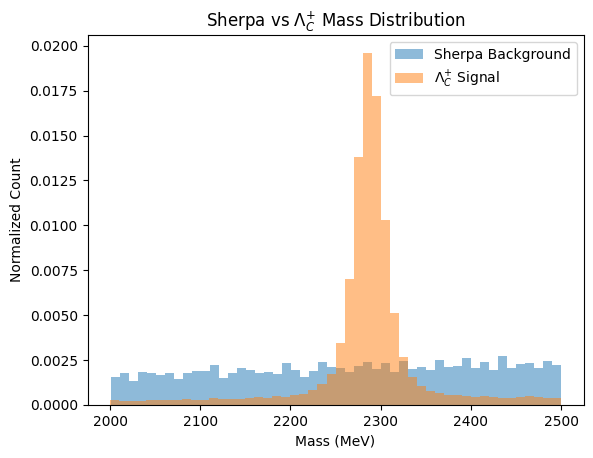

In [177]:
counts, bins, _ = plt.hist(passed_Background_both1["DMesons_m"], bins=50)
counts2, bins2, _ = plt.hist(passed_Signal_both2["DMesons_m"], bins=50)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs $\Lambda_C^{+}$ Mass Distribution")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

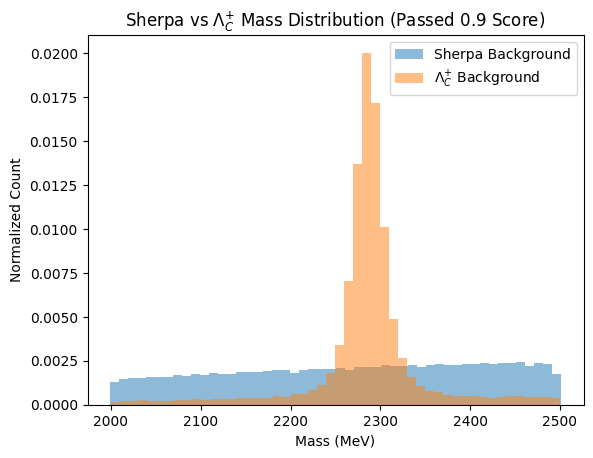

In [186]:
counts, bins, _ = plt.hist(passed_Background_both1["DMesons_m"], bins=50)
counts2, bins2, _ = plt.hist(passed_Background_both2["DMesons_m"], bins=50)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Background")
plt.title("Sherpa vs $\Lambda_C^{+}$ Mass Distribution (Passed 0.9 Score)")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

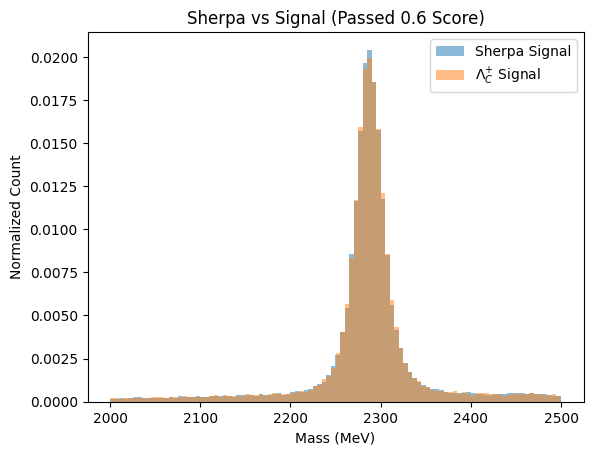

In [179]:
counts, bins, _ = plt.hist(passed_Signal_both1["DMesons_m"], bins=100)
counts2, bins2, _ = plt.hist(passed_Signal_both2["DMesons_m"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Signal")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs Signal (Passed 0.6 Score)")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

In [174]:
#predict accuract given y_test and predictions from model
def pred_accuracy(y_test, predictions):
    D_count, Lambda_count = 0, 0

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
            Lambda_count+=1
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            D_count+=1
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

accuracy_both = pred_accuracy(y_test, list(predictions_both2))
accuracy_background = pred_accuracy(y_test1, list(predictions_background2))
accuracy_signal = pred_accuracy(y_test2, list(predictions_signal2))

print("Accuracy for Both: {:.2%}".format(accuracy_both))
print("Accuracy for Only Background: {:.2%}".format(accuracy_background))
print("Accuracy for Only Signal: {:.2%}".format(accuracy_signal))

Accuracy for Both: 85.31%
Accuracy for Only Background: 78.50%
Accuracy for Only Signal: 91.92%


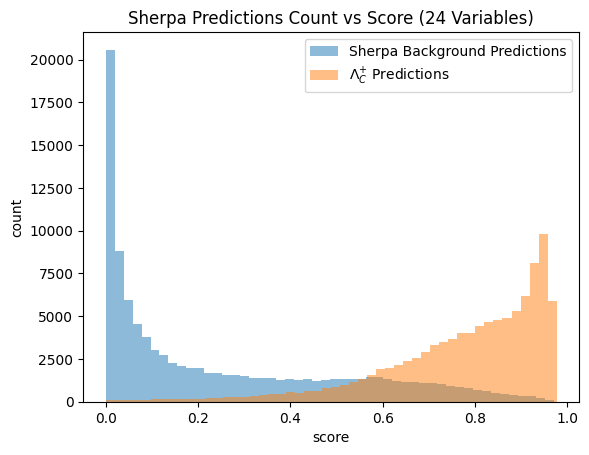

In [74]:
hist = plt.hist(predictions_background2, bins = 50, label = "Sherpa Background Predictions", alpha=0.5)
hist2 = plt.hist(predictions_signal2, bins = 50, label = "$\Lambda_C^{+}$ Predictions", alpha=0.5)
plt.xlabel("score")
plt.ylabel("count")
plt.title("Sherpa Predictions Count vs Score ({} Variables)".format(len(training_columns)))
plt.legend()
plt.show()

In [448]:
#bulk
y_true = list(y_test)
y_pred = predictions_both

In [496]:
#daughter
y_true1 = list(y_test)
y_pred1 = predictions_both1

In [497]:
#daughter + dalitz
y_true2 = list(y_test)
y_pred2 = predictions_both2

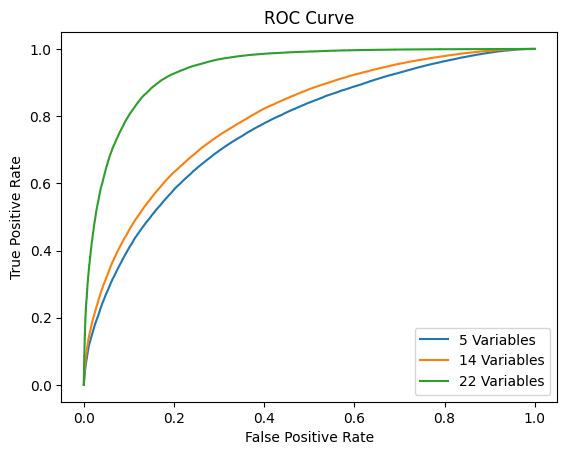

In [499]:
# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_pred1) 
fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_pred2) 

# Plot ROC curve
plt.plot(fpr, tpr, label = "5 Variables")
plt.plot(fpr1, tpr1, label = "14 Variables")
plt.plot(fpr2, tpr2, label = "22 Variables")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()